In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/snips-dataset/train_data.csv
/kaggle/input/snips-dataset/validate_data.csv


In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import confusion_matrix, accuracy_score

In [3]:
# import pandas as pd
# import numpy as np

In [4]:
from tqdm import tqdm

In [5]:
# Путь к файлу CSV
train_data_path = "/kaggle/input/snips-dataset/train_data.csv"
validate_data_path = "/kaggle/input/snips-dataset/validate_data.csv"

# Чтение данных из CSV-файлов
train_data = pd.read_csv(train_data_path)
validate_data = pd.read_csv(validate_data_path)

# Вывод первых 5 строк каждого DataFrame
print("Train data:")
print(train_data.head())
print("\nValidate data:")
print(validate_data.head())

Train data:
                       text       entity              intent
0  Please help me find the           NaN  SearchCreativeWork
1        Bloom: Remix Album  object_name  SearchCreativeWork
2                                    NaN  SearchCreativeWork
3                      song  object_type  SearchCreativeWork
4                         .          NaN  SearchCreativeWork

Validate data:
                  text       entity              intent
0    Wish to find the           NaN  SearchCreativeWork
1                movie  object_type  SearchCreativeWork
2                 the           NaN  SearchCreativeWork
3           Heart Beat  object_name  SearchCreativeWork
4  Please look up the           NaN  SearchCreativeWork


In [6]:
unique_values_normalized = train_data['intent'].value_counts(normalize=True)
print(unique_values_normalized)

intent
BookRestaurant          0.194746
GetWeather              0.175608
AddToPlaylist           0.157467
PlayMusic               0.149945
SearchCreativeWork      0.139878
SearchScreeningEvent    0.099889
RateBook                0.082467
Name: proportion, dtype: float64


In [7]:
train_data = train_data.drop('entity', axis=1)
validate_data = validate_data.drop('entity', axis=1)

In [8]:
# Удалите строки, где столбец 'column_name' пуст
train_data = train_data.dropna(subset=['text'])
validate_data = validate_data.dropna(subset=['text'])

In [9]:
# Подсчитываем количество примеров для каждого класса
class_counts = train_data['intent'].value_counts()

# Находим класс с наименьшим количеством примеров
min_class = class_counts.idxmin()
min_class_count = class_counts.min()

# Делаем undersampling для всех остальных классов
balanced_data = train_data[train_data['intent'] == min_class]
for intent in class_counts.index:
    if intent != min_class:
        samples = train_data[train_data['intent'] == intent].sample(min_class_count)
        balanced_data = pd.concat([balanced_data, samples], axis=0)

# Теперь в balanced_data примеры каждого класса представлены в одинаковом количестве

In [10]:
balanced_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10437 entries, 10357 to 2942
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10437 non-null  object
 1   intent  10437 non-null  object
dtypes: object(2)
memory usage: 244.6+ KB


In [11]:
from transformers import DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [12]:
class IntentClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [13]:
class EarlyStopping:
    def __init__(self, patience=2, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss


In [ ]:
from torch import nn
from transformers import DistilBertModel

class CustomDistilBertModel(nn.Module):
    def __init__(self, num_labels):
        super(CustomDistilBertModel, self).__init__()
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512, num_labels)

    def forward(self, input_ids, attention_mask):
        output = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = output[0][:, 0]
        output = self.dropout(pooled_output)
        output = self.fc1(output)
        output = nn.ReLU()(output)
        output = self.dropout(output)
        output = self.fc2(output)
        return output



In [14]:
# Преобразование меток в числовой формат
unique_intents = train_data['intent'].unique().tolist()
intent_mapping = {intent: i for i, intent in enumerate(unique_intents)}
train_labels = [intent_mapping[intent] for intent in balanced_data['intent']]
test_labels = [intent_mapping[intent] for intent in validate_data['intent']]

In [15]:
# Создание наборов данных PyTorch
max_len = 128
batch_size = 32 #16
train_dataset = IntentClassificationDataset(balanced_data['text'].tolist(), train_labels, tokenizer, max_len)
test_dataset = IntentClassificationDataset(validate_data['text'].tolist(), test_labels, tokenizer, max_len)

train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [16]:
from transformers import DistilBertForSequenceClassification, AdamW
import torch

# Загрузка модели DistilBERT
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(unique_intents))

# Компиляция модели
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [17]:
# Создание экземпляра класса EarlyStopping
early_stopping = EarlyStopping(patience=2, verbose=True)

In [18]:
# Замораживаем все параметры модели
for param in model.parameters():
    param.requires_grad = False

# Размораживаем параметры последнего слоя
for param in model.classifier.parameters():
    param.requires_grad = True


In [19]:
# Обучение модели
for epoch in range(50):
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_data_loader, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Обновление шкалы выполнения
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})

    # Расчет среднего значения потерь за эпоху
    avg_train_loss = total_loss / len(train_data_loader)
    print('Average training loss: ', avg_train_loss)

    # Валидация на независимом наборе данных
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in test_data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()

    avg_val_loss = val_loss / len(test_data_loader)
    print('Average validation loss: ', avg_val_loss)

#     early_stopping(avg_val_loss, model)

#     if early_stopping.early_stop:
#         print("Early stopping")
#         break

Average training loss:  1.9466128852389275
Average validation loss:  1.9403841694196065


Average training loss:  1.9401823041635915
Average validation loss:  1.9342450400193532


Average training loss:  1.9314410004776188
Average validation loss:  1.9294906208912532


Average training loss:  1.9266154270288776
Average validation loss:  1.9230261171857517


Average training loss:  1.9205059440128665
Average validation loss:  1.9177415072917938


Average training loss:  1.913952803757577
Average validation loss:  1.9123551348845165


Average training loss:  1.9081176701671123
Average validation loss:  1.9078684002161026


Average training loss:  1.9018083428024153
Average validation loss:  1.9024617075920105


Average training loss:  1.8969683278955816
Average validation loss:  1.895399736861388


Average training loss:  1.891360955865376
Average validation loss:  1.891718899210294


Average training loss:  1.8855365522046337
Average validation loss:  1.887679283817609


Average training loss:  1.8795373162727473
Average validation loss:  1.8839005678892136


Average training loss:  1.8763481794147316
Average validation loss:  1.8792696098486583


Average training loss:  1.8692287082701284
Average validation loss:  1.8730178376038868


Average training loss:  1.8649885913283089
Average validation loss:  1.8683330516020458


Average training loss:  1.8595606737545143
Average validation loss:  1.8639425709843636


Average training loss:  1.8557758473475046
Average validation loss:  1.8627303416530292


Average training loss:  1.850514290894208
Average validation loss:  1.8548606311281521


Average training loss:  1.8458112398054256
Average validation loss:  1.8524810820817947


Average training loss:  1.8421031900137572
Average validation loss:  1.8485338315367699


Average training loss:  1.8361919753777507
Average validation loss:  1.8438978269696236


Average training loss:  1.832208165334999
Average validation loss:  1.8409912412365277


Average training loss:  1.8278012414226474
Average validation loss:  1.8377498264114063


Average training loss:  1.8246702017769536
Average validation loss:  1.833013194302718


Average training loss:  1.8194672281224429
Average validation loss:  1.8271380712588627


Average training loss:  1.814869385611391
Average validation loss:  1.8246806760629017


Average training loss:  1.8118199445421177
Average validation loss:  1.8210316399733226


Average training loss:  1.8067811104135776
Average validation loss:  1.8151641935110092


Average training loss:  1.8036383547185029
Average validation loss:  1.8126678988337517


Average training loss:  1.800107665747313
Average validation loss:  1.8107970654964447


Average training loss:  1.7962166902122148
Average validation loss:  1.808452216287454


Average training loss:  1.7918714970259126
Average validation loss:  1.8041681473453839


Average training loss:  1.7885104888076082
Average validation loss:  1.7984538823366165


Average training loss:  1.7862271136100139
Average validation loss:  1.7979976957043011


Average training loss:  1.7814053774609113
Average validation loss:  1.793005349735419


Average training loss:  1.7783751232543852
Average validation loss:  1.7883328571915627


Average training loss:  1.7764751615874264
Average validation loss:  1.786963055531184


Average training loss:  1.7716171621182644
Average validation loss:  1.7830597708622615


Average training loss:  1.771115545103674
Average validation loss:  1.778740182518959


Average training loss:  1.7639887876102318
Average validation loss:  1.7771937474608421


Average training loss:  1.763831781320251
Average validation loss:  1.7747402464350064


Average training loss:  1.7604752866500015
Average validation loss:  1.7721494063735008


Average training loss:  1.7569375712572617
Average validation loss:  1.7665964265664418


Average training loss:  1.7536778380746871
Average validation loss:  1.7658076658844948


Average training loss:  1.7504128779110923
Average validation loss:  1.7622600918014844


Average training loss:  1.7494557126217296
Average validation loss:  1.7601752703388531


Average training loss:  1.7452996502593388
Average validation loss:  1.7546236738562584


Average training loss:  1.7417908731950533
Average validation loss:  1.7538455873727798


Average training loss:  1.739261207959703
Average validation loss:  1.7512932593623798


Average training loss:  1.737800101256881
Average validation loss:  1.749265489478906


In [20]:
# Предсказание на тестовых данных
model.eval()
predictions = []
with torch.no_grad():
    for batch in test_data_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)

        predictions.extend(preds)

predicted_labels = [pred.item() for pred in predictions]

In [21]:
# Расчет метрики accuracy
accuracy = accuracy_score(test_labels, predicted_labels)
print(f'Accuracy: {accuracy}')

Accuracy: 0.35467015022860876


In [22]:
# Построение confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)
print(f'Confusion Matrix: \n{cm}')

Confusion Matrix: 
[[ 20  64   9  28  45   5  15]
 [ 11  85  14  26  20  11  11]
 [  0  81 160   5  10   7  16]
 [  8  47   8  77  22  11  55]
 [ 12  23  15   4  42   5   8]
 [  7  70 102  20  32  58  20]
 [  7  69   4  41  15   5 101]]


In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

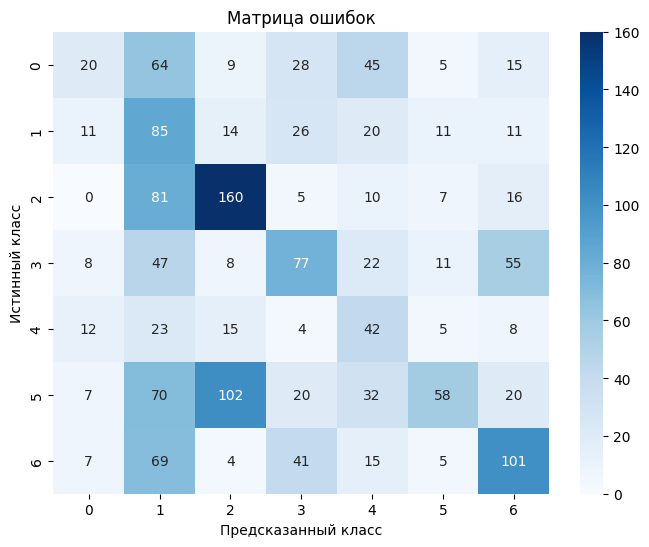

In [24]:
# Визуализация матрицы ошибок с использованием seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=set(test_labels), yticklabels=set(predicted_labels))
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title('Матрица ошибок')
plt.show()
